Andreu Gimenez Bolinches ([andreu@keio.jp](mailto:andreu@keio.jp))

This report has been written using an interactive Python notebook, which has
been then converted into `pdf`. One can find the source notebook in
the [code
repository](https://gitlab.com/jemaro/keio/space-exploration-engineering/mid-term-report).
The code shown here has been developed prioritizing readability and the
application of the concepts explained during the lectures. The execution
efficiency is then not a priority.

Initially we will import some general libraries.

In [1]:
# Python 3.8.4
import numpy as np
from sympy import *
from ipywidgets import *
from typing import Optional, List, Tuple, Union
from IPython.display import display, Math
from datetime import timedelta
from matplotlib import rcParams
from matplotlib_inline.backend_inline import set_matplotlib_formats

rcParams['text.usetex'] = True
rcParams['figure.figsize'] = [12.0, 6.0]
rcParams['savefig.dpi'] = 300
set_matplotlib_formats('pdf', 'retina')

import matplotlib.pyplot as plt
from mpl_toolkits.axisartist.axislines import SubplotZero

init_printing()


# Printing utility function
def disp(*expresions: list):
    string = ''
    for expr in expresions:
        if isinstance(expr, str):
            string += expr
        elif isinstance(expr, np.ndarray):
            string += latex(Matrix(expr))
        else:
            string += latex(expr)
    display(Math(string))

# Hohmann Transfer
![A1](images/A1.jpg)

<div style="page-break-after: always; visibility: hidden"> 
\pagebreak 
</div>

## Orbit objects
First of all, we'll define some Orbit objects. A general Kepler orbit around
earth `EarthOrbit` which
takes as input the eccentricity and the semi-latus rectum and provides the
property of the angular momentum as well as methods for distance to Earth and
velocity depending on the true anomaly $\theta$. 

In [2]:
from functools import cached_property
from unyt.array import unyt_quantity
from unyt import km, m, s, radian


class EarthOrbit:
    # Constants:
    mu = (3.986e5 * km**3 / s**2).in_mks()  # Gravitational parameter on Earth
    R = 6378e3 * m  # Earth radius

    def __init__(
            self,
            p: unyt_quantity,  # Semi-latus rectum
            e: float,  # Eccentricity
        ) -> None:
        self.p = p.in_mks()
        self.e = e
        # Vectorized functions that can take arrays as input
        self.r = np.vectorize(self._r)
        self.v = np.vectorize(self._v)
        self.w = np.vectorize(self._w)

    @cached_property
    def H(self) -> unyt_quantity:
        # Angular momentum
        return np.sqrt(self.p * self.mu)

    def _r(self, theta: unyt_quantity = 0 * radian) -> unyt_quantity:
        # Distance to Earth
        return self.p / (1 + self.e * np.cos(theta))

    def _v(self, theta: unyt_quantity = 0 * radian) -> unyt_quantity:
        # Linear velocity
        return self.H / self._r(theta)

    def _w(self, theta: unyt_quantity = 0 * radian) -> unyt_quantity:
        # Angular velocity
        return self._v(theta) / self._r(theta)

<div style="page-break-after: always; visibility: hidden"> 
\pagebreak 
</div>

Secondly, `EarthOrbit` subclasses which adapts the necessary input depending on
the shape (circle or ellipse) as well as providing shape specific properties.

In [3]:
class CircularOrbit(EarthOrbit):
    def __init__(
            self,
            r: unyt_quantity,  # Radius
            is_height: bool = False,  # Wether is height over Earth radius
        ) -> None:
        if is_height:
            r = r + self.R
        super().__init__(r, 0)

    @property
    def radius(self) -> unyt_quantity:
        return self.p


class EllipticOrbit(EarthOrbit):
    def __init__(
            self,
            rp: unyt_quantity,  # Perigee radii
            ra: unyt_quantity,  # Apogee radii
            is_height: bool = False,  # Wether is height over Earth radius
        ) -> None:
        if is_height:
            ra = ra + self.R
            rp = rp + self.R
        e = (ra - rp) / (ra + rp)
        p = rp * (1 + e)
        super().__init__(p, e)

    @property
    def v_apogee(self) -> unyt_quantity:
        return self._v(np.pi * radian)

    @property
    def v_perigee(self) -> unyt_quantity:
        return self._v(0)

<div style="page-break-after: always; visibility: hidden"> 
\pagebreak 
</div>

Then, we define a function that will make use of the Orbit objects with the
objective of defining a Hohmann transfer between two radii (`r1` and `r2`).
If `rm` is provided and it is different than `r1` and `r2`, a _Bi-elliptic
Hohmann transfer_ will be used with `rm` as the apoapsis radius.
Otherwise, a _Hohmann transfer_ will be used. 

This functions returns a list of the Orbit objects used as well as the energy
efficiency defined as the absolute velocity differences at orbit changes
divided by the initial orbit velocity ($\Delta \overline{V} = \Delta V / V_o$)
as defined in the problem statement.

In [4]:
def hohmann_transfer(
    r1: unyt_quantity,
    r2: unyt_quantity,
    rm: Optional[unyt_quantity] = None,
    is_height: bool = False,
    ):
    # Start with a circular orbit defined by r1
    orbits = [CircularOrbit(r1, is_height=is_height)]
    Vdiff = 0
    Vo = orbits[0].v()
    if rm is None or rm == r1 or rm == r2:  # Pure Hohmann transfer
        # Just one intermediate elliptic orbit is needed
        orbits.append(EllipticOrbit(r1, r2, is_height=is_height))
        Vdiff += abs(orbits[-1].v_perigee - Vo)
        Vapproach = orbits[-1].v_apogee
    else:  # Bi-elliptic Hohmann transfer
        # Two intermediate elliptic orbits are needed
        orbits.append(EllipticOrbit(r1, rm, is_height=is_height))
        Vdiff += abs(orbits[-1].v_perigee - Vo)
        orbits.append(EllipticOrbit(r2, rm, is_height=is_height))
        Vdiff += abs(orbits[-1].v_apogee - orbits[-2].v_apogee)
        Vapproach = orbits[-1].v_perigee
    # We will allways end in a circular orbit defined by r2
    orbits.append(CircularOrbit(r2, is_height=is_height))
    Vdiff += abs(orbits[-1].v() - Vapproach)
    return {
        'DeltaV': (Vdiff / Vo).to_value(),
        'Vdiff': Vdiff,
        'orbits': orbits,
        }


<div style="page-break-after: always; visibility: hidden"> 
\pagebreak 
</div>
We can test the function and the Orbit objects with the values from Example 6.3 of the textbook:

In [5]:
rA = 7000 * km
rB = 210e3 * km
rC = rD = 105e3 * km
T1 = hohmann_transfer(rA, rC, rB)
disp(
    r'\Delta V_{total})_\text{Bi-elliptic}=', T1['Vdiff'].to_value(km / s),
    '\, km/s'
    )
T2 = hohmann_transfer(rA, rD)
disp(
    r'\Delta V_{total})_\text{Hohmann}=', T2['Vdiff'].to_value(km / s),
    '\, km/s'
    )


<IPython.core.display.Math object>

<IPython.core.display.Math object>

The results shown above match the ones of the textbook, proving that our Orbit
objects and Hohmann transfer function work as expected.

<div style="page-break-after: always; visibility: hidden"> 
\pagebreak 
</div>

## Plots

We can now use the mentioned Orbit objects and the transfer function to plot
some visualizations.

### Orbit

Let's start by visualizing the trajectory of the transfer itself. The
trajectory of the transfer is divided in one or two intermediate orbits,
therefore, we can develop a function that plots any orbit `plot_orbit` using
polar coordinates and iterate over the transfer `orbits` in another function
`plot_orbits`.

In [6]:
def plot_orbit(
        ax: plt.Axes,
        orbit: EllipticOrbit,
        *,
        theta: float = np.linspace(0, 2 * np.pi, 100),
        **kwargs,
    ):
    r = orbit.r(theta)
    ax.plot(theta, r, **kwargs)


def plot_orbits(
    ax: plt.Axes,
    orbits: List[EllipticOrbit],
    ):
    for i, orbit in enumerate(orbits):
        kwargs = {}
        if i == 0:
            kwargs['color'] = 'k'
        elif i == len(orbits) - 1:
            kwargs['linestyle'] = '--'
            kwargs['color'] = 'k'
        else:
            kwargs['theta'] = np.linspace((1 - i) % 2 * np.pi,
                                          (2 - i % 2) * np.pi, 100)
        plot_orbit(ax, orbit, label=str(i), **kwargs)
    ax.set_ylabel(r'$r[m]$')
    ax.tick_params(
        axis='x',  # changes apply to the x-axis
        which='both',  # both major and minor ticks are affected
        bottom=False,  # ticks along the bottom edge are off
        top=False,  # ticks along the top edge are off
        labelbottom=False
        )  # labels along the bottom edge are off
    ax.legend(loc='lower right')


<div style="page-break-after: always; visibility: hidden"> 
\pagebreak 
</div>
Now we can plot the transfers that we have calculated above with the values
from the Example 6.3 of the textbook.

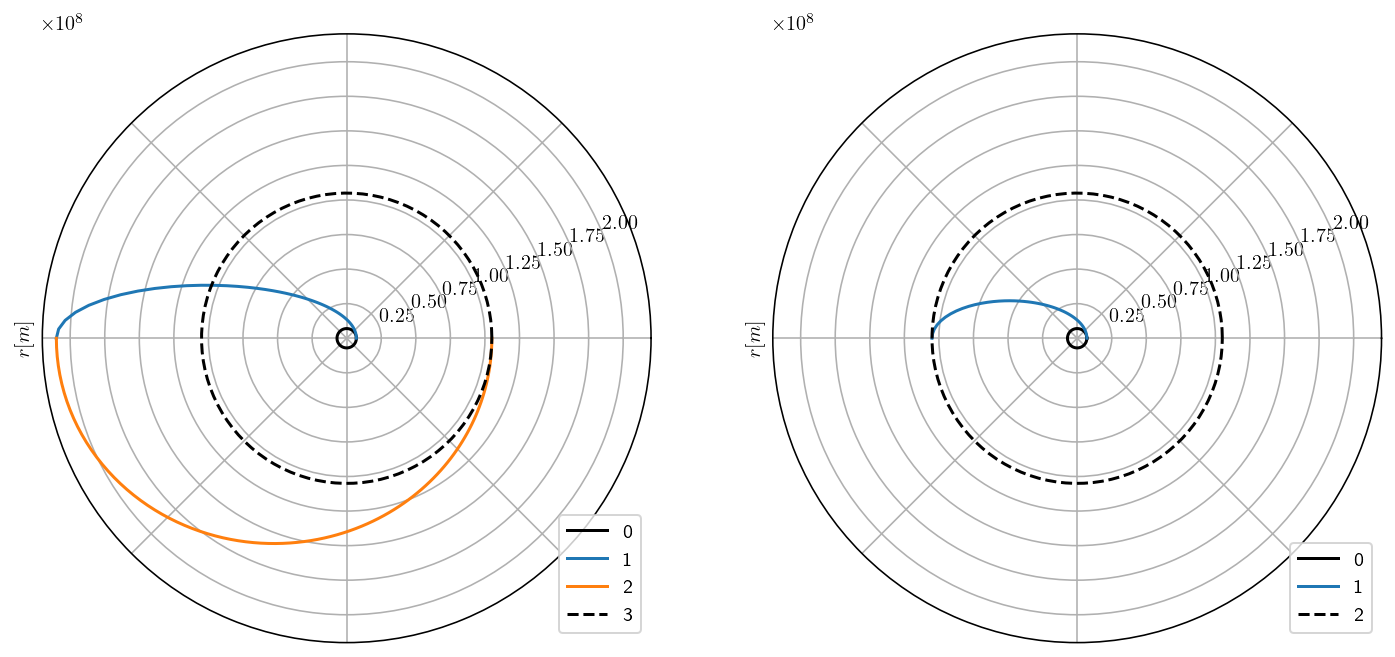

In [7]:
fig, (ax_1, ax_2) = plt.subplots(1, 2, subplot_kw={'projection': 'polar'})
plot_orbits(ax_1, T1['orbits'])
plot_orbits(ax_2, T2['orbits'])
_ = ax_2.set_ylim(ax_1.get_ylim())


### $r_{21} - \Delta \overline{V}$

Visualizing the transfer trajectory is nice, but it is not very useful in terms
of analyzing how efficient the transfer is compared to others. That's why we
will plot a transfer efficiency indicator against some parameters that define
the transfer.

A good energy efficiency indicator is the absolute velocity changes needed
during the transfer $\Delta V$, the larger it is, the less efficient the
transfer is. We can nondimensionalize it dividing it by the transfer starting
velocity $V_o$ (which corresponds to the starting orbit):

$$\Delta \overline{V} = \frac{\Delta V}{V_o}$$

Our transfer depends only on three parameters, the starting orbit radii $r_1$,
the final orbit radii $r_2$ and the maneuver apoapsis $r_m$ in case of a
bi-elliptic transfer. As the energy efficiency has been nondimensionalized
using the initial orbit, we should do the same with these parameters:

$$
r_{21} = \frac{r_2}{r_1} \quad
r_{m1} = \frac{r_m}{r_1}
$$

We can develop then a function that plots $r_{21} - \Delta \overline{V}$ with
different $r_m1$, `plot_DeltaV`:

In [8]:
def plot_DeltaV(
    ax: Optional[plt.Axes] = None,
    r1: unyt_quantity = 7000 * km,
    r21_range: Tuple[float, float] = [10, 20],
    r21_steps: int = 500,
    rm1: List[float] = [1, 10, 20, 30],
    highlight_rm1: float = None,
    highlight_r21: Optional[float] = None,
    ):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    r21 = np.linspace(*r21_range, num=r21_steps)
    if not isinstance(rm1, list):
        rm1 = list(rm1)
    if highlight_rm1 is not None:
        assert highlight_rm1 in rm1
    for _rm1 in rm1:
        DV = [
            hohmann_transfer(r1, r1 * _r21, r1 * _rm1)['DeltaV']
            for _r21 in r21
            ]
        ax.plot(
            r21,
            DV,
            linewidth=3 if highlight_rm1 == _rm1 else 1,
            label=r'$r_{m1}=' + f'{_rm1:3.2f}$'
            )
    ax.legend()
    ax.set_xlabel(r'$r_{21}$')
    ax.set_ylabel(r'$\Delta \overline{V}$')
    if highlight_r21 is not None:
        ax.axvline(highlight_r21, color='k', linestyle='--')

<div style="page-break-after: always; visibility: hidden"> 
\pagebreak 
</div>

Finally, we can plot how the energy efficiency of the proposed transfers in
textbook's Example 6.3 would have changed with a different final orbit $r_2$.

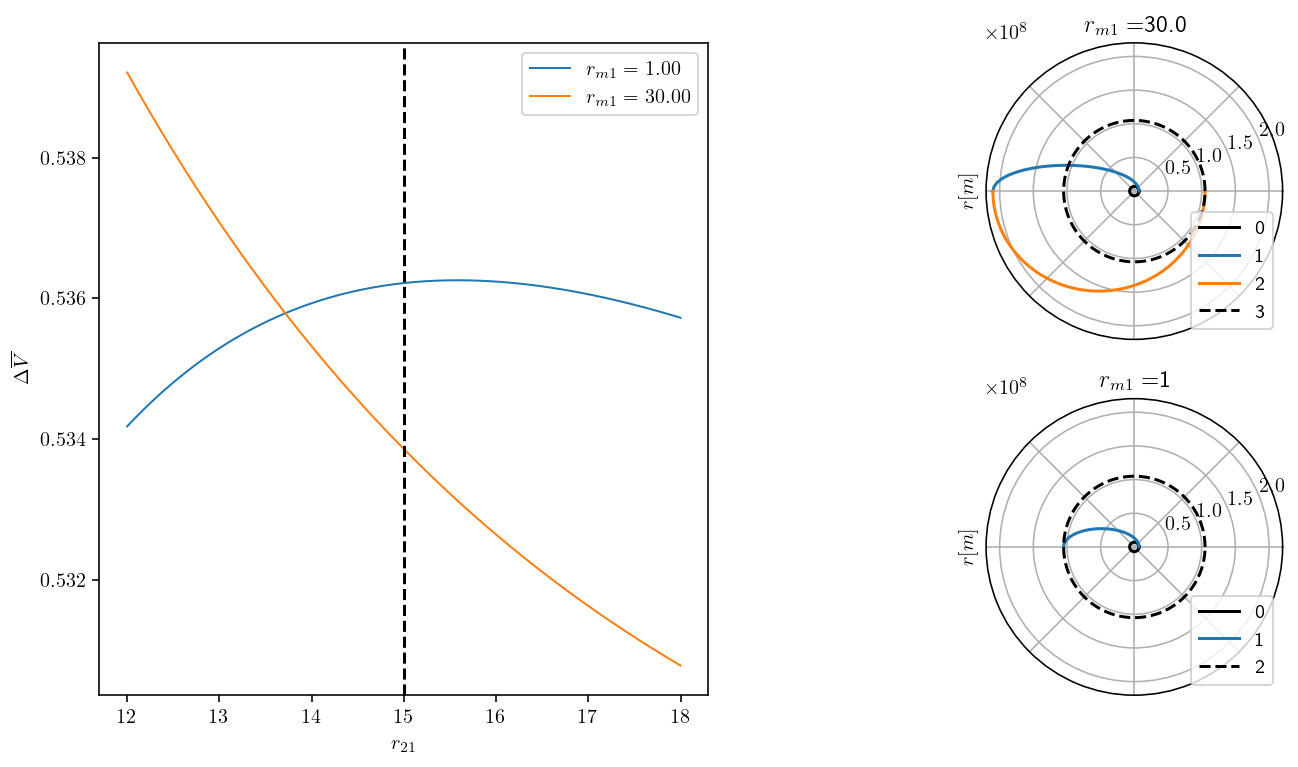

In [9]:
fig = plt.figure()
ax_DeltaV = fig.add_subplot(121)
ax_orbits1 = fig.add_subplot(222, projection='polar')
ax_orbits2 = fig.add_subplot(224, projection='polar')
r21 = rC / rA
rm1 = [1, (rB / rA).to_value()]  # [Hohmann, Bi-elliptic]
plot_DeltaV(
    ax_DeltaV,
    r1=rA,
    r21_range=r21 * [0.8, 1.2],
    rm1=rm1,
    highlight_r21=r21,
    )
plot_orbits(ax_orbits1, T1['orbits'])
ax_orbits1.set_title(r'$r_{m1}=$' + str((rB / rA).to_value()))
plot_orbits(ax_orbits2, T2['orbits'])
ax_orbits2.set_ylim(ax_orbits1.get_ylim())
_ = ax_orbits2.set_title(r'$r_{m1}=$1')

<div style="page-break-after: always; visibility: hidden"> 
\pagebreak 
</div>

### Interactive

We can bundle these plot functions with an interactive tool in order to explore
different transfers. User interfaces can become quite lengthy and complicated
in terms of code, even if they are conceptually easy to understand.

In [10]:
%matplotlib widget

In [11]:
%%capture
# Comment the line above to see the plot in the notebook
w = {
    'r21_range':
        IntRangeSlider(
            value=[10, 20],
            min=0,
            max=50,
            description=r'\(r_{21}\) range',
            continuous_update=False,
            ),
    'r1':
        FloatSlider(
            value=7000,
            min=6378,
            max=100e3,
            step=1,
            description=r'\(r_{1} [km]\)'
            ),
    'r21_steps':
        IntSlider(
            value=500, min=100, max=1000, description=r'\(r_{21}\) steps'
            ),
    'rm1_list':
        Text(
            value='1, 10, 20, 30',
            description=r'\(r_{m1}\) options',
            continuous_update=False,
            ),
    'r21':
        FloatSlider(
            value=15,
            min=10,
            max=20,
            description=r'\(r_{21}\)',
            continuous_update=False
            ),
    'rm1':
        SelectionSlider(
            options=[1, 10, 20, 30],
            description=r'\(r_{m1}\)',
            continuous_update=False
            ),
    }

ui = VBox([
    HBox(x) for x in zip(list(w.values())[::2],
                         list(w.values())[1::2])
    ])


def update_r21_range(*args):
    w['r21'].max = w['r21_range'].value[1]
    w['r21'].min = w['r21_range'].value[0]
    w['r21'].value = min(w['r21'].max, max(w['r21'].min, w['r21'].value))


w['r21_range'].observe(update_r21_range, 'value')


def update_rm1_list(*args):
    options = [float(x) for x in w['rm1_list'].value.split(',')]
    if w['rm1'].value not in options:
        w['rm1'].value = options[0]
    w['rm1'].options = options


w['rm1_list'].observe(update_rm1_list, 'value')

fig = plt.figure()
ax_DeltaV = fig.add_subplot(121)
ax_orbits = fig.add_subplot(122, projection='polar')


def interactive_DeltaV(
    r1: float = 7000,  # [km]
    r21_range: Tuple[float, float] = (10, 20),
    r21_steps: int = 500,
    rm1_list: str = '1, 10, 20, 30',
    r21: float = 15,
    rm1: float = 1,
    ):
    # Process interactive input
    r1 = r1 * km
    rm1_float_list = []
    for x in rm1_list.split(','):
        try:
            rm1_float_list.append(float(x))
        except ValueError:
            print('rm1 options must be numbers, {x} is not')
    w['rm1_list'].value = ', '.join(map(str, rm1_float_list))
    ax_DeltaV.clear()
    ax_orbits.clear()
    # Make plots
    plot_DeltaV(
        ax_DeltaV, r1, r21_range, r21_steps, rm1_float_list, highlight_rm1=rm1
        )
    ax_DeltaV.axvline(r21, c='k', ls='--')
    transfer = hohmann_transfer(r1, r1 * r21, r1 * rm1)
    plot_orbits(ax_orbits, transfer['orbits'])
    ax_orbits.set_title(r'$r_{m1}=$' + str(rm1) + r'   $r_{21}=$' + str(r21))


out = interactive_output(interactive_DeltaV, w)

display(ui, out)

<div style="page-break-after: always; visibility: hidden"> 
\pagebreak 
</div>

Unfortunately, interactive cells are not rendered in the report, clone the [code
repository](https://gitlab.com/jemaro/keio/space-exploration-engineering/mid-term-report)
in order to use it:

![interactive](images/interactive.jpg)

In [12]:
%matplotlib inline

<div style="page-break-after: always; visibility: hidden"> 
\pagebreak 
</div>

## Conclusion

There might be a window of initial to end orbit ratio $r_{21}$ values where the
Hohmann transfer is less efficient than the Bi-elliptic Hohmann transfer
depending also on the maneuver apoapsis ratio to the initial transfer orbit
radii $r_{m1}$. The bigger $r_{m1}$ is, the bigger the window. We can observe
that as $r_{m0}$ increases, the lower and upper bounds of this window decrease
and increase respectively too.

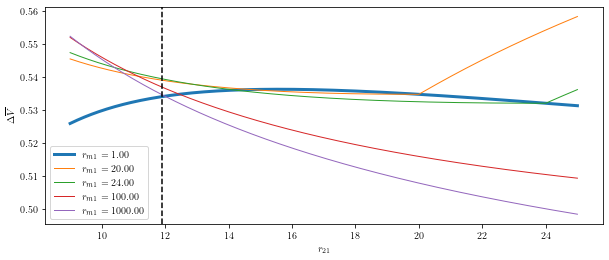

In [13]:
plot_DeltaV(
    rm1=[1, 20, 24, 100, 1000],
    r21_range=[9, 25],
    highlight_r21=11.9,
    highlight_rm1=1
    )

The upper bound increases linearly with $r_{m1}$:


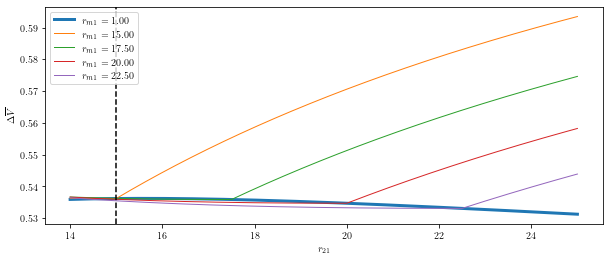

In [14]:
plot_DeltaV(
    rm1=[1.0, 15.0, 17.5, 20.0, 22.5],
    r21_range=[14, 25],
    highlight_r21=15,
    highlight_rm1=1
    )

While the lower bound seems to converge around $11.9$:

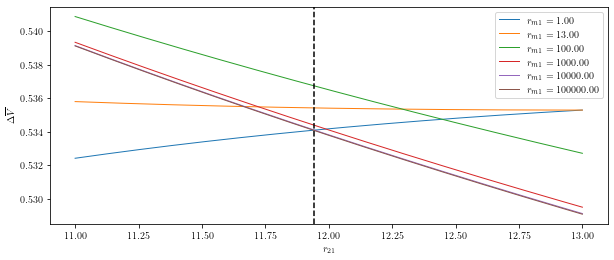

In [15]:
plot_DeltaV(
    rm1=[1, 13, 1e2, 1e3, 1e4, 1e5],
    r21_range=[11, 13],
    highlight_r21=11.94,
    )

<div style="page-break-after: always; visibility: hidden"> 
\pagebreak 
</div>

Section 6.4 of the textbook presents the analytical solution of Hohmann and
Bi-elliptic Hohmann transfer $\Delta \overline(V)$:

In [16]:
r21, rm1 = symbols('r_{21}, r_{m1}')
DeltaV_H = 1 / sqrt(r21) - sqrt(2) * (1 - r21) / sqrt(r21 * (1 + r21)) - 1
disp('\Delta \overline{V}_{H} = ', DeltaV_H)
DeltaV_BE = (
    sqrt(2 * (r21 + rm1) / (r21 * rm1)) - (1 + sqrt(r21)) / sqrt(r21) -
    sqrt(2) * (1 - rm1) / sqrt(rm1 * (1 + rm1))
    )
disp('\Delta \overline{V}_{BE} = ', DeltaV_BE)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

We can then calculate said where exactly the lower bound of the window
converges as $r_{m1}$ increases.

In [17]:
lim_DeltaV_BE = limit(DeltaV_BE, rm1, oo)
disp(r'\lim\limits_{r_{m1}\to\infty}\Delta\overline{V}_{BE}=', lim_DeltaV_BE)
n_lb = N(solve(lim_DeltaV_BE - DeltaV_H, r21, numerical=True)[0], chop=True)
disp(
    r'\Delta\overline{V}_{H}=',
    r'\lim\limits_{r_{m1}\to\infty}\Delta\overline{V}_{BE}',
    r'\quad\quad r_{21}=', n_lb
    )


<IPython.core.display.Math object>

<IPython.core.display.Math object>

This value corresponds to the necessary conditions for a more energy efficient
Bi-elliptic Hohmann transfer. If $r_{21}$ is lower than $11.94$, a Bi-elliptic
Hohmann transfer will never be more efficient than it's Hohmann transfer
counterpart.

$$\textit{Necessary} \quad r_{m1} > r_{21} > 11.94$$

We can also calculate the $r_{21}$ value that corresponds to the maximum
efficiency of a Hohmann transfer.

In [18]:
s_ub = N(solve(diff(DeltaV_H, r21), r21, numerical=True)[0], chop=True)
disp(r'\frac{d}{d r_{21}}\Delta\overline{V}_{H}=0\quad\quad r_{21}=', s_ub)

<IPython.core.display.Math object>

Which correspond to the sufficient conditions for a more energy efficient
Bi-elliptic Hohmann transfer. As long as this conditions are satisfied, a
Bi-elliptic Hohmann transfer will always be more efficient than it's Hohmann
transfer counterpart.

$$\textit{Sufficient} \quad r_{m1} > r_{21} > 15.58$$

In the case that $15.58 > r_{m1} > r_{21} > 11.94$, to determine which transfer
method will be more efficient we need to compute their efficiency. We could use
the equations provided before. Large values of $r_{m1}$ favour the Bi-elliptic
transfer while smaller values favour the Hohmann transfer.

What is certain, is that the Bi-Elliptic maneuver implies a longer time of
flight to perform the transfer. Therefore, even if we assume that the maneuver
apoapsis $r_m$ can be infinitely large without risking the mission, it adds
another trade-off where not only energy efficiency should be considered, but
also the transfer duration.

As a final remark on this exercise, the analytical equations derived to compute
an orbit $\Delta\overline{V}$ given only $r_{21}$ and $r_{m1}$ could be used to
generate the plots presented above in a much more computationally efficient
way. Nevertheless as it has been mentioned at the beginning of the report, code
development has been focused on concepts and readability instead of efficiency.

<div style="page-break-after: always; visibility: hidden"> 
\pagebreak 
</div>

# Two-impulse rendezvous maneuver

![A2a](images/A2a.jpg)

![A2b](images/A2b.jpg)

<div style="page-break-after: always; visibility: hidden"> 
\pagebreak 
</div>

## Clohessy-Wiltshire matrix

We will start by defining the matrix that relates an state $[X, V]$ composed of
position and velocity with the initial conditions. The variables of this matrix
are angular velocity $\omega$ and angular position $\theta$ which can be
obtained from the angular velocity and the time elapsed $\theta = \omega t$.

From a technical point of view, this matrix is defined as a subclass of
`numpy.ndarray` with a modified initialization. Only the parameters `w`
($\omega$) and `t` (time) are needed to instantiate the array but it will work
well with other `numpy` methods like matrix multiplications, pseudo-inverse,
etc. Additionally, it allows us to access the submatrices with an easy syntax,
being `cw` an instance of the `CW` array, `cw[1,1]` is the top left `3x3`
matrix.

In [19]:
class CW(np.ndarray):
    def __new__(
            cls,
            w=Symbol(r'\omega'),  # Angular velocity
            t=Symbol(r't'),  # Time
        ):
        th = w * t
        if isinstance(w, Symbol):
            st = sin(th)
            ct = cos(th)
        else:
            st = np.sin(th)
            ct = np.cos(th)
        _11 = np.array([
            [1, 0, 6 * (st - th)],
            [0, ct, 0],
            [0, 0, 4 - 3 * ct],
            ])
        _12 = np.array([
            [(4 / w) * st - 3 * t, 0, (2 / w) * (ct - 1)],
            [0, (1 / w) * st, 0],
            [(2 / w) * (1 - ct), 0, (1 / w) * st],
            ])
        _21 = np.array([
            [0, 0, 6 * w * (ct - 1)],
            [0, -w * st, 0],
            [0, 0, 3 * w * st],
            ])
        _22 = np.array([
            [4 * ct - 3, 0, -2 * st],
            [0, ct, 0],
            [2 * st, 0, ct],
            ])
        obj = np.block([[_11, _12], [_21, _22]]).view(cls)
        obj.th = th
        obj.w = w
        obj.t = t
        return obj

    def __array_finalize__(self, obj):
        if obj is None: return
        self.th = getattr(obj, 'th', None)
        self.w = getattr(obj, 'w', None)
        self.t = getattr(obj, 't', None)

    def __getitem__(self, key):
        # Use our own indexing scheme where CW is subdivided in 4 matrices
        return super().__getitem__(
            tuple(slice(3 * (k - 1), 3 * k) for k in key)
            )


cw = CW()

In [20]:
x, y, z, vx, vy, vz, x0, y0, z0, vx0, vy0, vz0 = symbols(
    r'x, y, z, \dot{x}, \dot{y}, \dot{z}, ' +
    r'x_0, y_0, z_0, \dot{x_0}, \dot{y_0}, \dot{z_0}'
    )
_X = Matrix([x, y, z])
_V = Matrix([vx, vy, vz])
_X0 = Matrix([x0, y0, z0])
_V0 = Matrix([vx0, vy0, vz0])
disp(Matrix.vstack(_X, _V), '=', cw, Matrix.vstack(_X0, _V0))

<IPython.core.display.Math object>

<div style="page-break-after: always; visibility: hidden"> 
\pagebreak 
</div>

## Analytical solution of initial velocity

Once the Clohessy-Wiltshire matrix has been defined, we can use it to compute
the initial velocity given the initial position `X0` and the constraint that
the position at the end time `T` will be the origin of coordinates 
($X(T) = [0, 0, 0]$).

The function `V0` computes the initial velocity vector. If no symbolic
variables are provided, the computation will be performed with numerical
algorithms. Otherwise the calculus will be performed symbolically. Here we can
find the symbolic solution that depends on the initial position ($x_0$, $y_0$,
$z_0$), the duration of the maneuver $T$, and the angular velocity $\omega$.

In [21]:
def V0(
        CW_T: CW = CW(t=Symbol('T')),
        X0=Matrix(symbols('x_0, y_0, z_0')),  # Initial position
    ):
    # Applies the constriant X(T) = 0 in order to compute the initial velocity
    # given the maneuver duration, angular velocity and the initial position.
    # V0 = CW[1,2]^(-1) * CW[1,1] * X0
    try:
        # Use a faster numeric inverse algorithm
        return -np.linalg.inv(CW_T[1, 2]) @ CW_T[1, 1] @ X0
    except TypeError:  # Symbolic variables will raise an exception
        # Use a symbolic inverse algorithm
        return simplify(-Matrix(CW_T[1, 2]).inv() @ Matrix(CW_T[1, 1]) @ X0)


disp(_V0, '=', V0())

<IPython.core.display.Math object>

## Analytical solution of velocity at $t = T$

With the initial velocity we now have the complete initial state $[X_0, V_0]$,
which allows us to compute any other state given the angular velocity $\omega$
and the time $t$. We can therefore analytically solve the final velocity $V_T$
when time $t = T$.

In [22]:
CW_T = CW(*symbols('w, T'))
A21 = Matrix(CW_T[2, 1])
A22 = Matrix(CW_T[2, 2])
_VT = A21 @ _X0 + A22 @ V0(CW_T, _X0)
disp(_V, '_{t=T} =', simplify(_VT))

<IPython.core.display.Math object>

<div style="page-break-after: always; visibility: hidden"> 
\pagebreak 
</div>

## Trajectory drawing

The next step is to compute and draw trajectories with the objects already
defined. 

### Trajectory

First, we need to compute a trajectory given some initial position of the
chaser frame $[x_0, y_0, z_o]$, the target height `h_t`, the maneuver duration
`T` and the number of steps to be used when simulating the trajectory.
Additionally, our `trajectory` function allows to input the initial velocity of
the chaser (`dz0`, `dy0`, `dz0`), if it is not provided, it will be computed
using the constrain $X(T) = 0$ as explained in the [analytical solution of
initial velocity](#analytical-solution-of-initial-velocity).

In [23]:
def trajectory(
    # Initial position w.r.t. target [m]
    x0: int = 200,
    y0: int = 0,
    z0: int = 0,
    # Initial velocity w.r.t. target [m/s]
    dx0: Optional[float] = None,
    dy0: Optional[float] = None,
    dz0: Optional[float] = None,
    *,
    # maneuver scenario
    h_t: int = 400,  # Target height [km]
    T: float = 5000,  # maneuver duration [s]
    # Simulation configuration
    steps: int = 100,
    ):

    # Target setup
    O_target = CircularOrbit(r=h_t * km, is_height=True)
    w = O_target._w().to_value()

    # Chaser setup
    _X0 = np.array([[x0], [y0], [z0]])
    if all(v is None for v in [dx0, dy0, dz0]):
        # Compute initial velocity that ensures X(T) = 0
        _V0 = V0(CW(w, T), _X0)
    else:
        # Use provided initial velocity
        _V0 = np.array([[dx0 or 0], [dy0 or 0], [dz0 or 0]])

    # Iterate and concateate position vectors columnwise in the array X
    X = _X0
    for t in np.flip(np.linspace(T, 0, steps, endpoint=False)):
        cw = CW(w, t)
        X = np.c_[X, cw[1, 1] @ _X0 + cw[1, 2] @ _V0]
    return X

<div style="page-break-after: always; visibility: hidden"> 
\pagebreak 
</div>

### Plot

Given an array `X` of stacked position column vectors, we can now draw the
trajectory. The function `plot_trajectory` will take care of using the function
`trajectory` and plot the results.

In [24]:
def plot_trajectory(
    *args,
    fig: Optional[plt.Figure] = None,
    ax_XZ: Union[bool, plt.Axes] = True,
    T: float = 5000,  # maneuver duration [s]
    **kwargs,
    ):
    if fig is None:
        fig = plt.figure(figsize=(10, 4))
    axes = []
    X = trajectory(*args, T=T, **kwargs)
    if ax_XZ:
        if not isinstance(ax_XZ, plt.Axes):
            ax_XZ = SubplotZero(fig, 111)
            fig.add_subplot(ax_XZ)
        xz0 = (X[0, 0], X[2, 0])
        ax_XZ.clear()
        ax_XZ.plot(
            *xz0,
            'o',
            markersize=10,
            markeredgecolor='k',
            markerfacecolor='y',
            label='Chaser initial position'
            )
        ax_XZ.plot(X[0, :], X[2, :], 'k-', label='Chaser trajectory')
        for direction in ["xzero", "yzero"]:
            ax_XZ.axis[direction].set_axisline_style("-|>")
            ax_XZ.axis[direction].set_visible(True)
        for direction in ["left", "right", "bottom", "top"]:
            ax_XZ.axis[direction].set_visible(False)
        ax_XZ.grid(b=True, axis='both')
        ax_XZ.set_ylabel('z [m]')
        ax_XZ.set_xlabel('x [m]')
        ax_XZ.set_title(f'Orbit plane: Duration {timedelta(seconds=T)}')
        ax_XZ.legend()
        axes.append(ax_XZ)
    return axes

<div style="page-break-after: always; visibility: hidden"> 
\pagebreak 
</div>

We can check the behaviour of our functions with Example 7.5 from the textbook.
One can see that figure 7.11 from the textbook draws the same results as the
illustration below:

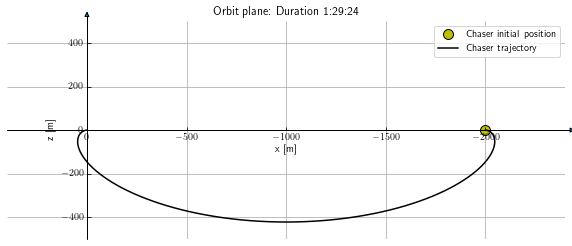

In [25]:
ax_XZ, *_ = plot_trajectory(x0=-2000, T=5364, h_t=300)
ax_XZ.set_ylim(-500, 500)
_ = ax_XZ.set_xlim(400, -2400)

Moreover, we can also check the trajectory when an arbitrary initial velocity
is given. It is easy to find the characteristic spiral motion in the target.

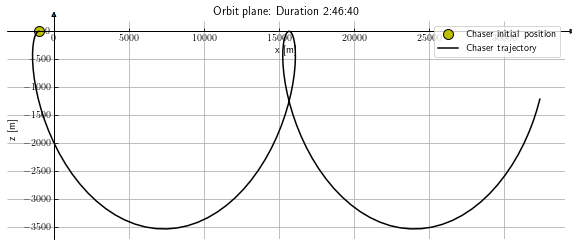

In [26]:
_ = plot_trajectory(x0=-1000, dx0=-1, T=1e4)

### Interactive

We will make use again of interactive user interfaces in order to explore the
behaviour of the Two-Impulse Rendezvous Maneuver. However, the interface is
simpler this time.

In [27]:
%matplotlib widget

In [28]:
%%capture
# Comment the line above to see the plot in the notebook

fig = plt.figure()
ax_XZ = SubplotZero(fig, 111)
fig.add_subplot(ax_XZ)


@interact(
    x0=(-200, 200),
    y0=(-200, 200),
    z0=(-200, 200),
    T=(1000, 10000)
    )
def interactive_plot_trajectory(*args, **kwargs):
    plot_trajectory(fig=fig, ax_XZ=ax_XZ, **kwargs)

Unfortunately again, interactive cells are not rendered in the report, clone
the [code
repository](https://gitlab.com/jemaro/keio/space-exploration-engineering/mid-term-report)
in order to use it:

![interactive](images/interactiveA2b.jpg)

In [29]:
%matplotlib inline

## Conclusions

The trajectory of a chaser spacecraft that needs to arrive at the target
position at $t = T$ has been analytically studied as well as simulated and
drawn.

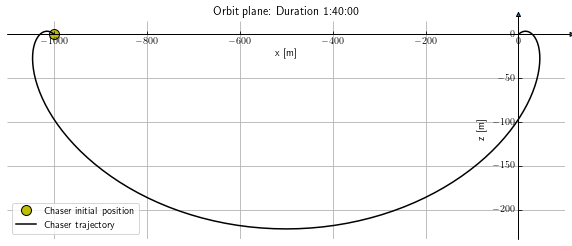

In [30]:
_ = plot_trajectory(x0=-1000, T=6000)